In [20]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, binned_statistic_dd
from mpl_toolkits.mplot3d import Axes3D

In [21]:
file = "../data/SSCURVES.xlsx"

In [22]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [23]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

100%|███████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.65it/s]


No person id information found for 62
No person id information found for 555
    index          a          k        xc        r2  person_id
0       1   9.722284  25.765146  1.286479  0.997758          1
1       2   4.980775  34.981564  1.329463  0.998321          1
2       3   5.809952  36.377351  1.427317  0.999670          2
3       4   1.488651  41.075665  1.344725  0.999545          2
4       5  11.070994  22.631975  1.255611  0.997075          3
..    ...        ...        ...       ...       ...        ...
56     57   2.220456  19.453294  1.256554  0.999190         18
57     58   3.173915  16.109134  1.326089  0.999199         18
58     59   3.275427  20.755613  1.264770  0.999109         18
59     60   3.782172  16.488657  1.274944  0.997922         18
60     61   2.538357  18.426224  1.277699  0.997563         18

[61 rows x 6 columns]


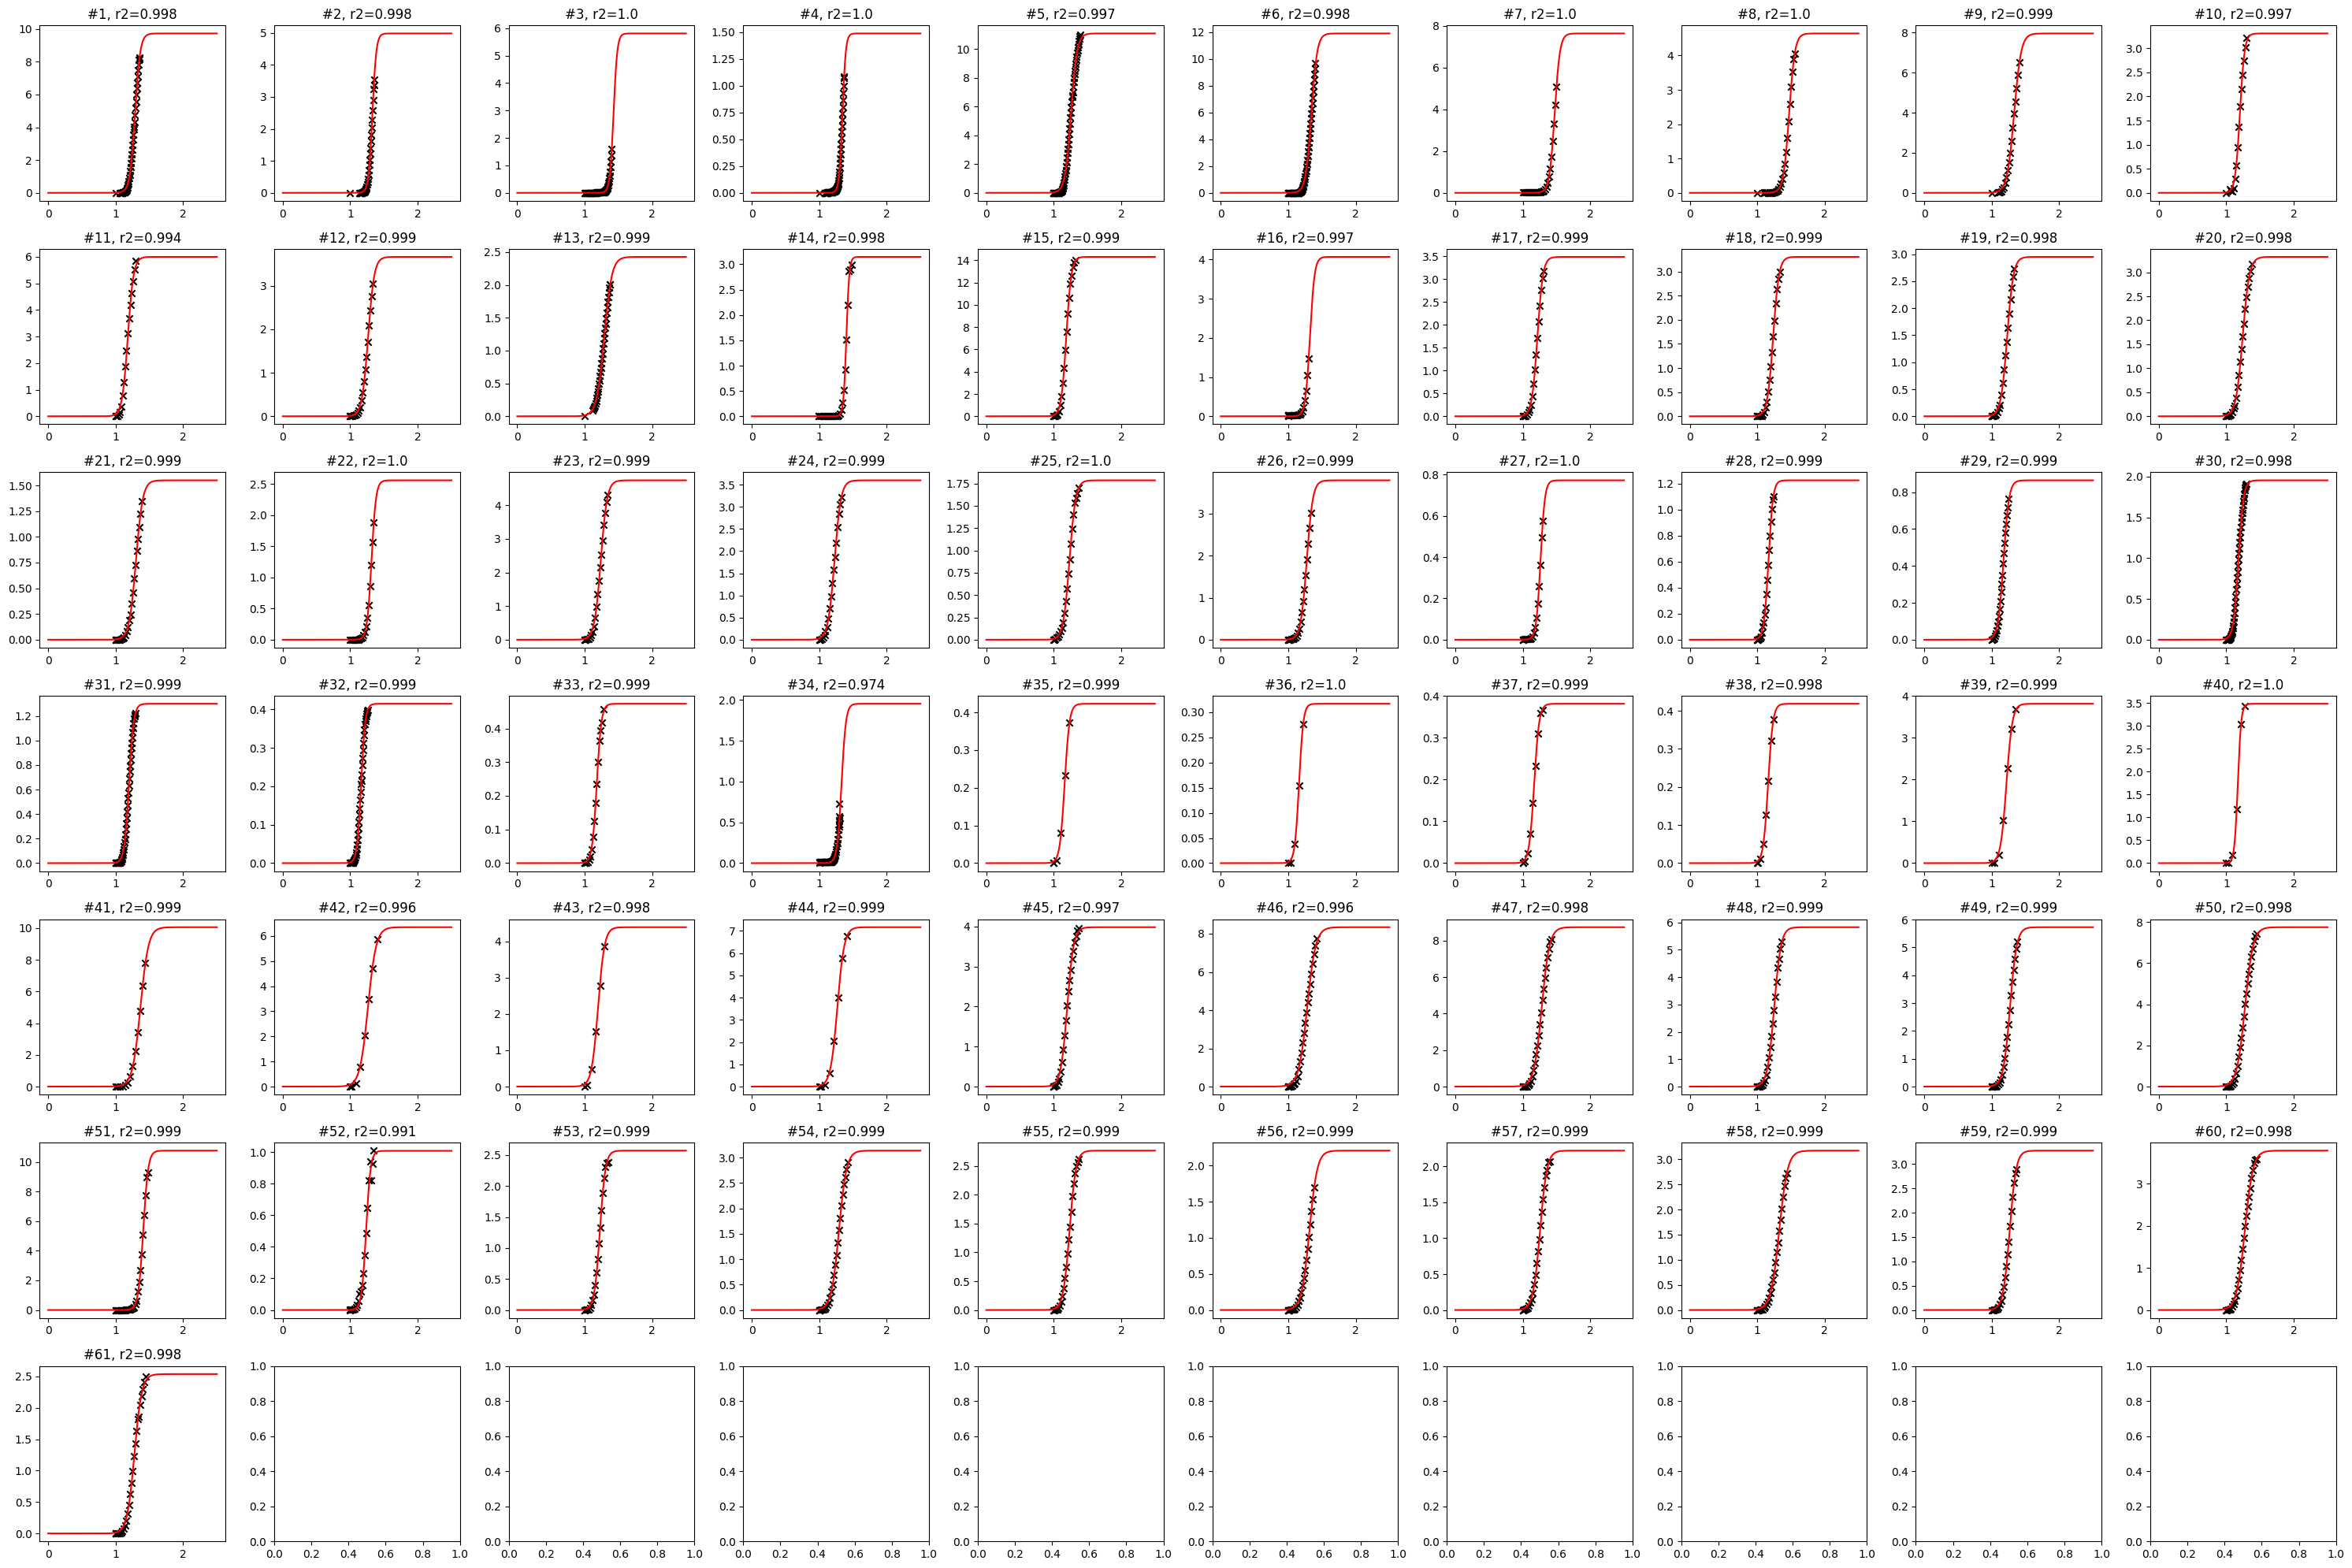

In [24]:
xls = pd.ExcelFile(file)

index_list =  []
person_ids = []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)


for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        continue

    person_ids.append(person_id)

    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    popt, _ = curve_fit(logistic, x_data, y_data, bounds=((0, -np.inf, -np.inf), (np.inf, np.inf, np.inf)), maxfev=10000)#bounds=((0, -np.inf,-np.inf,0),(np.inf, np.inf, np.inf,np.inf)), maxfev=10000)
    index_list.append(int(sheet))
    a_list.append(popt[0])
    k_list.append(popt[1])
    xc_list.append(popt[2])

    r2 = r2_fn(y_data, logistic(x_data, *popt))
    r2_list.append(r2)

    ax.scatter(x_data, y_data, marker='x', color='black')
    ax.plot(x, logistic(x, *popt), 'r-')
    ax.set_title(f"#{sheet}, r2={round(r2, 3)}")


data = {
    "index": index_list,

    "a": a_list,
    "k": k_list,
    "xc": xc_list,
    "r2": r2_list,
    "person_id": person_ids,
}

df = pd.DataFrame.from_dict(data)
print(df)

plt.tight_layout()
plt.savefig("outputs/logistic_fits.png")
plt.show()


In [25]:
df.to_csv("outputs/logistic_targets.csv", index=False) # We have our own indices.

array([[<AxesSubplot: title={'center': 'person_id'}>]], dtype=object)

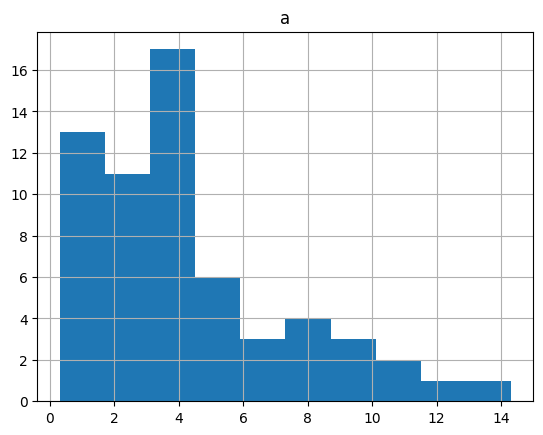

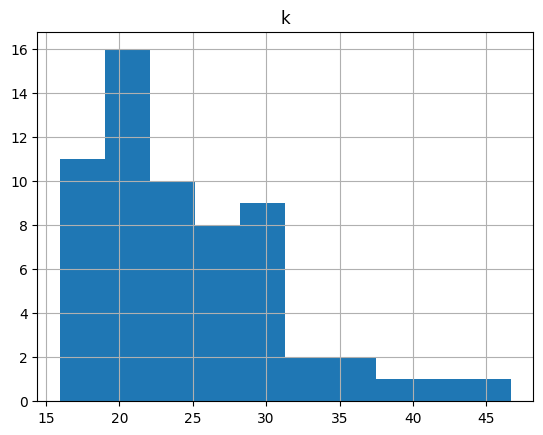

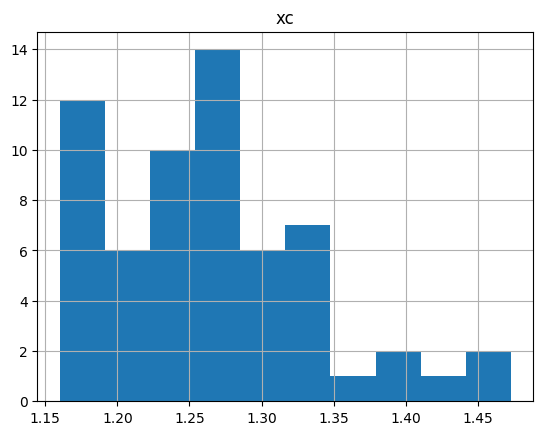

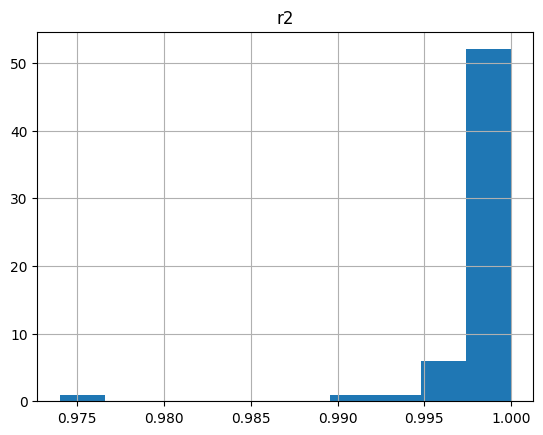

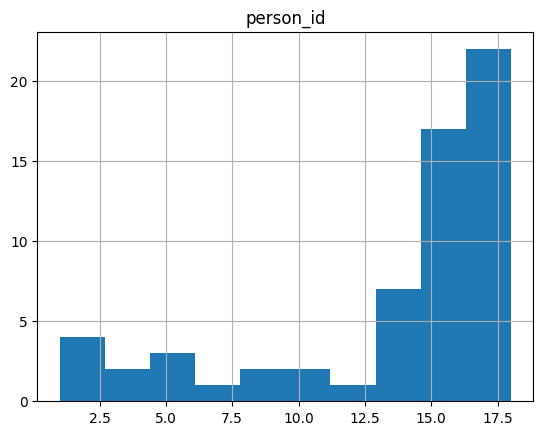

In [26]:
df.hist(column='a')
df.hist(column='k')
df.hist(column='xc')
df.hist(column='r2')
df.hist(column='person_id')